In [1]:
import os
import torch
torch.manual_seed(42)
import torchaudio
torchaudio.set_audio_backend("ffmpeg")  # Enable mp3 support
import numpy as np
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torch import nn, optim
from tqdm import tqdm
 # For progress bar

# Check for CUDA
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


C:\Users\nikhi\AppData\Local\Temp\ipykernel_20424\1535039857.py:5: UserWarning: torchaudio._backend.set_audio_backend has been deprecated. With dispatcher enabled, this function is no-op. You can remove the function call.
  torchaudio.set_audio_backend("ffmpeg")  # Enable mp3 support


In [2]:
class VoiceDataset(Dataset):
    def __init__(self, real_dir, fake_dir, transform, max_frames=100):
        self.file_paths = []
        self.labels = []
        for f in os.listdir(real_dir):
            self.file_paths.append(os.path.join(real_dir, f))
            self.labels.append(0)  # 0 = Real
        for f in os.listdir(fake_dir):
            self.file_paths.append(os.path.join(fake_dir, f))
            self.labels.append(1)  # 1 = Fake
        self.transform = transform
        self.max_frames = max_frames

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        filepath = self.file_paths[idx]
        label = self.labels[idx]
        waveform, sr = torchaudio.load(filepath)
        waveform = waveform.mean(dim=0, keepdim=True)  # Enforce mono
        if sr != 16000:
            waveform = torchaudio.transforms.Resample(sr, 16000)(waveform)
        mfcc = self.transform(waveform)  # [1, n_mfcc, frames]
        if mfcc.size(2) < self.max_frames:
            pad_amt = self.max_frames - mfcc.size(2)
            mfcc = nn.functional.pad(mfcc, (0, pad_amt))
        else:
            mfcc = mfcc[:, :, :self.max_frames]
        return mfcc, label

# Paths and parameters
real_dir = r"C:\Users\nikhi\OneDrive\Desktop\dsp\Deepfake\KAGGLE\Audio\Real"
fake_dir = r"C:\Users\nikhi\OneDrive\Desktop\dsp\Deepfake\KAGGLE\Audio\Fake"
sample_rate = 16000
n_mfcc = 40
max_frames = 100
batch_size = 4

# MFCC transform
mfcc_transform = torchaudio.transforms.MFCC(
    sample_rate=sample_rate,
    n_mfcc=n_mfcc,
    melkwargs={"n_fft": 400, "hop_length": 160, "n_mels": 40}
)

# Instantiate dataset
dataset = VoiceDataset(real_dir, fake_dir, mfcc_transform, max_frames)

# Compute sample weights to handle imbalance
class_counts = np.bincount(dataset.labels)
class_weights = 1.0 / class_counts
sample_weights = [class_weights[label] for label in dataset.labels]
sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

dataloader = DataLoader(dataset, batch_size=batch_size, sampler=sampler)


In [3]:
class CNNVoiceDetector(nn.Module):
    def __init__(self):
        super(CNNVoiceDetector, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(32, 2)

    def forward(self, x):
        x = self.pool(torch.relu(self.bn1(self.conv1(x))))
        x = self.pool(torch.relu(self.bn2(self.conv2(x))))
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)

model = CNNVoiceDetector().to(device)


In [4]:
model.load_state_dict(torch.load('deepfake_voice_detector.pth', map_location=device))
model.to(device)


CNNVoiceDetector(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (global_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=32, out_features=2, bias=True)
)

In [9]:
# Cell 4: Training loop (prints loss and accuracy after each epoch)
num_epochs = 25  # Increased the number of epochs

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

best_acc = 0.0  # To track the best accuracy
best_epoch = 0  # To track the epoch with best accuracy

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    
    for inputs, labels in tqdm(dataloader, desc="Training", unit="batch"):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    
    epoch_loss = running_loss / total
    epoch_acc = 100.0 * correct / total
    print(f"Epoch {epoch+1} Completed - Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%")
    
    # Track the best accuracy and the corresponding epoch
    if epoch_acc > best_acc:
        best_acc = epoch_acc
        best_epoch = epoch + 1  # Store the epoch number (1-based)

# After training, print the best epoch and its accuracy
print(f"\nBest Accuracy: {best_acc:.2f}% at Epoch {best_epoch}")



Epoch 1/25


Training: 100%|██████████| 16/16 [00:23<00:00,  1.46s/batch]


Epoch 1 Completed - Loss: 0.2885, Accuracy: 95.31%

Epoch 2/25


Training: 100%|██████████| 16/16 [00:25<00:00,  1.60s/batch]


Epoch 2 Completed - Loss: 0.2908, Accuracy: 85.94%

Epoch 3/25


Training: 100%|██████████| 16/16 [00:25<00:00,  1.61s/batch]


Epoch 3 Completed - Loss: 0.3212, Accuracy: 87.50%

Epoch 4/25


Training: 100%|██████████| 16/16 [00:25<00:00,  1.58s/batch]


Epoch 4 Completed - Loss: 0.2452, Accuracy: 92.19%

Epoch 5/25


Training: 100%|██████████| 16/16 [00:23<00:00,  1.44s/batch]


Epoch 5 Completed - Loss: 0.2099, Accuracy: 93.75%

Epoch 6/25


Training: 100%|██████████| 16/16 [00:24<00:00,  1.51s/batch]


Epoch 6 Completed - Loss: 0.1981, Accuracy: 95.31%

Epoch 7/25


Training: 100%|██████████| 16/16 [00:22<00:00,  1.44s/batch]


Epoch 7 Completed - Loss: 0.2878, Accuracy: 90.62%

Epoch 8/25


Training: 100%|██████████| 16/16 [00:26<00:00,  1.68s/batch]


Epoch 8 Completed - Loss: 0.2594, Accuracy: 92.19%

Epoch 9/25


Training: 100%|██████████| 16/16 [00:26<00:00,  1.67s/batch]


Epoch 9 Completed - Loss: 0.3199, Accuracy: 89.06%

Epoch 10/25


Training: 100%|██████████| 16/16 [00:22<00:00,  1.40s/batch]


Epoch 10 Completed - Loss: 0.2371, Accuracy: 95.31%

Epoch 11/25


Training: 100%|██████████| 16/16 [00:22<00:00,  1.43s/batch]


Epoch 11 Completed - Loss: 0.3206, Accuracy: 89.06%

Epoch 12/25


Training: 100%|██████████| 16/16 [00:24<00:00,  1.53s/batch]


Epoch 12 Completed - Loss: 0.2771, Accuracy: 92.19%

Epoch 13/25


Training: 100%|██████████| 16/16 [00:24<00:00,  1.53s/batch]


Epoch 13 Completed - Loss: 0.2634, Accuracy: 92.19%

Epoch 14/25


Training: 100%|██████████| 16/16 [00:26<00:00,  1.64s/batch]


Epoch 14 Completed - Loss: 0.2891, Accuracy: 93.75%

Epoch 15/25


Training: 100%|██████████| 16/16 [00:28<00:00,  1.80s/batch]


Epoch 15 Completed - Loss: 0.2985, Accuracy: 89.06%

Epoch 16/25


Training: 100%|██████████| 16/16 [00:26<00:00,  1.68s/batch]


Epoch 16 Completed - Loss: 0.2661, Accuracy: 89.06%

Epoch 17/25


Training: 100%|██████████| 16/16 [00:29<00:00,  1.82s/batch]


Epoch 17 Completed - Loss: 0.1818, Accuracy: 98.44%

Epoch 18/25


Training: 100%|██████████| 16/16 [00:28<00:00,  1.78s/batch]


Epoch 18 Completed - Loss: 0.2128, Accuracy: 95.31%

Epoch 19/25


Training: 100%|██████████| 16/16 [00:24<00:00,  1.55s/batch]


Epoch 19 Completed - Loss: 0.2074, Accuracy: 96.88%

Epoch 20/25


Training: 100%|██████████| 16/16 [00:23<00:00,  1.45s/batch]


Epoch 20 Completed - Loss: 0.2189, Accuracy: 93.75%

Epoch 21/25


Training: 100%|██████████| 16/16 [00:25<00:00,  1.57s/batch]


Epoch 21 Completed - Loss: 0.2636, Accuracy: 90.62%

Epoch 22/25


Training: 100%|██████████| 16/16 [00:25<00:00,  1.59s/batch]


Epoch 22 Completed - Loss: 0.2402, Accuracy: 93.75%

Epoch 23/25


Training: 100%|██████████| 16/16 [00:26<00:00,  1.67s/batch]


Epoch 23 Completed - Loss: 0.2251, Accuracy: 93.75%

Epoch 24/25


Training: 100%|██████████| 16/16 [00:25<00:00,  1.61s/batch]


Epoch 24 Completed - Loss: 0.2148, Accuracy: 95.31%

Epoch 25/25


Training: 100%|██████████| 16/16 [00:26<00:00,  1.68s/batch]

Epoch 25 Completed - Loss: 0.1666, Accuracy: 96.88%

Best Accuracy: 98.44% at Epoch 17


In [12]:
torch.save(model.state_dict(), "deepfake_voice_detector.pth")
print("Model saved to deepfake_voice_detector.pth")

Model saved to deepfake_voice_detector.pth


In [ ]:
# ----- Prediction function using CNNVoiceDetector -----
def predict(file_path, transform, max_frames=100):
    # Instantiate and load your model
    model = CNNVoiceDetector().to(device)
    model.load_state_dict(torch.load("deepfake_voice_detector.pth", map_location=device))
    model.eval()

    try:
        waveform, sr = torchaudio.load(file_path)
    except Exception as e:
        return f"Error loading audio: {e}"

    waveform = waveform.mean(dim=0, keepdim=True)
    if sr != sample_rate:
        waveform = torchaudio.transforms.Resample(sr, sample_rate)(waveform)
    mfcc = transform(waveform)
    if mfcc.size(2) < max_frames:
        mfcc = nn.functional.pad(mfcc, (0, max_frames - mfcc.size(2)))
    else:
        mfcc = mfcc[:, :, :max_frames]
    mfcc = mfcc.to(device).unsqueeze(0)

    with torch.no_grad():
        outputs = model(mfcc)
        _, pred = torch.max(outputs, 1)
    return "Real" if pred.item() == 0 else "Fake"



In [20]:
# Example usage:
print(predict(r"linus-original-DEMO.mp3", mfcc_transform))

Real


<Figure size 800x600 with 0 Axes>

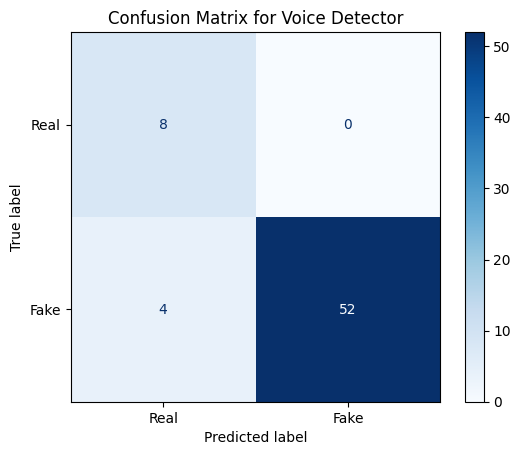

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import torch
from torch.utils.data import DataLoader

# Create a DataLoader for evaluation (without sampler to avoid bias)
eval_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

# Set model to evaluation mode
model.eval()

# Collect predictions and true labels
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in eval_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Define class names based on your dataset
class_names = ['Real', 'Fake']  # 0 = Real, 1 = Fake

# Plot confusion matrix and save to file
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title('Confusion Matrix for Voice Detector')
plt.savefig('confusion_matrix.png')

In [7]:
class GenderVoiceDataset(Dataset):
    def __init__(self, real_dir, fake_dir, transform, max_frames=100):
        self.file_paths = []
        self.labels = []
        for folder in [real_dir, fake_dir]:
            for f in os.listdir(folder):
                f_lower = f.lower()
                if not f_lower.endswith('.wav'):
                    continue
                if "_female" in f_lower:
                    self.file_paths.append(os.path.join(folder, f))
                    self.labels.append(0)  # Female
                elif "_male" in f_lower:
                    self.file_paths.append(os.path.join(folder, f))
                    self.labels.append(1)  # Male
        self.transform = transform
        self.max_frames = max_frames

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        filepath = self.file_paths[idx]
        label = self.labels[idx]
        waveform, sr = torchaudio.load(filepath)
        waveform = waveform.mean(dim=0, keepdim=True)
        if sr != 16000:
            waveform = torchaudio.transforms.Resample(sr, 16000)(waveform)
        mfcc = self.transform(waveform)
        if mfcc.size(2) < self.max_frames:
            pad_amt = self.max_frames - mfcc.size(2)
            mfcc = nn.functional.pad(mfcc, (0, pad_amt))
        else:
            mfcc = mfcc[:, :, :self.max_frames]
        return mfcc, label


In [8]:
# Cell 3: CNN Model Definition
class GenderCNN(nn.Module):
    def __init__(self):
        super(GenderCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, (3, 3), padding=1)
        self.pool1 = nn.MaxPool2d((2, 2))
        self.conv2 = nn.Conv2d(32, 64, (3, 3), padding=1)
        self.pool2 = nn.MaxPool2d((2, 2))
        self.conv3 = nn.Conv2d(64, 128, (3, 3), padding=1)
        self.pool3 = nn.MaxPool2d((2, 2))
        self.fc1 = nn.Linear(128 * 5 * 12, 128)  # For (n_mfcc=40, max_frames=100)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 2)  # Binary classes

    def forward(self, x):
        x = self.pool1(torch.relu(self.conv1(x)))
        x = self.pool2(torch.relu(self.conv2(x)))
        x = self.pool3(torch.relu(self.conv3(x)))
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


In [9]:
# Cell 4: Config and Data Preparation
real_dir = r"C:\Users\nikhi\OneDrive\Desktop\dsp\Deepfake\KAGGLE\Audio\Real"
fake_dir = r"C:\Users\nikhi\OneDrive\Desktop\dsp\Deepfake\KAGGLE\Audio\Fake"
sample_rate = 16000
n_mfcc = 40
max_frames = 100
batch_size = 4

mfcc_transform = torchaudio.transforms.MFCC(
    sample_rate=sample_rate,
    n_mfcc=n_mfcc,
    melkwargs={"n_fft": 400, "hop_length": 160, "n_mels": 40}
)

dataset = GenderVoiceDataset(real_dir, fake_dir, mfcc_transform, max_frames)
class_counts = np.bincount(dataset.labels)
class_weights = 1.0 / class_counts
sample_weights = [class_weights[label] for label in dataset.labels]
sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)
dataloader = DataLoader(dataset, batch_size=batch_size, sampler=sampler)


In [10]:
# 1. Instantiate the model
model = GenderCNN().to(device)

# 2. Load the saved weights
model.load_state_dict(torch.load("gender_detector.pth"))
print("Loaded model weights from gender_detector.pth")

# 3. Set up loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Loaded model weights from gender_detector.pth


In [16]:
# Cell 5: Model Instantiation and Training
num_epochs = 25
best_acc = 0.0
best_epoch = 0

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    
    for inputs, labels in tqdm(dataloader, desc="Training", unit="batch"):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    
    epoch_loss = running_loss / total
    epoch_acc = 100.0 * correct / total
    print(f"Epoch {epoch+1} Completed - Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%")
    
    if epoch_acc > best_acc:
        best_acc = epoch_acc
        best_epoch = epoch + 1

print(f"\nBest Accuracy: {best_acc:.2f}% at Epoch {best_epoch}")



Epoch 1/25


Training: 100%|██████████| 16/16 [00:30<00:00,  1.88s/batch]


Epoch 1 Completed - Loss: 0.1616, Accuracy: 95.31%

Epoch 2/25


Training: 100%|██████████| 16/16 [00:24<00:00,  1.55s/batch]


Epoch 2 Completed - Loss: 0.0079, Accuracy: 100.00%

Epoch 3/25


Training: 100%|██████████| 16/16 [00:24<00:00,  1.56s/batch]


Epoch 3 Completed - Loss: 0.0750, Accuracy: 96.88%

Epoch 4/25


Training: 100%|██████████| 16/16 [00:24<00:00,  1.55s/batch]


Epoch 4 Completed - Loss: 0.0005, Accuracy: 100.00%

Epoch 5/25


Training: 100%|██████████| 16/16 [00:28<00:00,  1.80s/batch]


Epoch 5 Completed - Loss: 0.0001, Accuracy: 100.00%

Epoch 6/25


Training: 100%|██████████| 16/16 [00:25<00:00,  1.58s/batch]


Epoch 6 Completed - Loss: 0.4631, Accuracy: 92.19%

Epoch 7/25


Training: 100%|██████████| 16/16 [00:23<00:00,  1.44s/batch]


Epoch 7 Completed - Loss: 0.1685, Accuracy: 96.88%

Epoch 8/25


Training: 100%|██████████| 16/16 [00:22<00:00,  1.39s/batch]


Epoch 8 Completed - Loss: 0.3776, Accuracy: 93.75%

Epoch 9/25


Training: 100%|██████████| 16/16 [00:25<00:00,  1.58s/batch]


Epoch 9 Completed - Loss: 0.0733, Accuracy: 96.88%

Epoch 10/25


Training: 100%|██████████| 16/16 [00:28<00:00,  1.75s/batch]


Epoch 10 Completed - Loss: 0.0300, Accuracy: 98.44%

Epoch 11/25


Training: 100%|██████████| 16/16 [00:25<00:00,  1.57s/batch]


Epoch 11 Completed - Loss: 0.0678, Accuracy: 98.44%

Epoch 12/25


Training: 100%|██████████| 16/16 [00:23<00:00,  1.44s/batch]


Epoch 12 Completed - Loss: 0.0217, Accuracy: 98.44%

Epoch 13/25


Training: 100%|██████████| 16/16 [00:24<00:00,  1.51s/batch]


Epoch 13 Completed - Loss: 0.0517, Accuracy: 96.88%

Epoch 14/25


Training: 100%|██████████| 16/16 [00:25<00:00,  1.59s/batch]


Epoch 14 Completed - Loss: 0.0951, Accuracy: 98.44%

Epoch 15/25


Training: 100%|██████████| 16/16 [00:24<00:00,  1.51s/batch]


Epoch 15 Completed - Loss: 0.0229, Accuracy: 98.44%

Epoch 16/25


Training: 100%|██████████| 16/16 [00:24<00:00,  1.56s/batch]


Epoch 16 Completed - Loss: 0.0011, Accuracy: 100.00%

Epoch 17/25


Training: 100%|██████████| 16/16 [00:23<00:00,  1.45s/batch]


Epoch 17 Completed - Loss: 0.0023, Accuracy: 100.00%

Epoch 18/25


Training: 100%|██████████| 16/16 [00:27<00:00,  1.70s/batch]


Epoch 18 Completed - Loss: 0.0001, Accuracy: 100.00%

Epoch 19/25


Training: 100%|██████████| 16/16 [00:22<00:00,  1.40s/batch]


Epoch 19 Completed - Loss: 0.0000, Accuracy: 100.00%

Epoch 20/25


Training: 100%|██████████| 16/16 [00:23<00:00,  1.46s/batch]


Epoch 20 Completed - Loss: 0.0002, Accuracy: 100.00%

Epoch 21/25


Training: 100%|██████████| 16/16 [00:27<00:00,  1.72s/batch]


Epoch 21 Completed - Loss: 0.0000, Accuracy: 100.00%

Epoch 22/25


Training: 100%|██████████| 16/16 [00:24<00:00,  1.53s/batch]


Epoch 22 Completed - Loss: 0.0005, Accuracy: 100.00%

Epoch 23/25


Training: 100%|██████████| 16/16 [00:24<00:00,  1.53s/batch]


Epoch 23 Completed - Loss: 0.0000, Accuracy: 100.00%

Epoch 24/25


Training: 100%|██████████| 16/16 [00:23<00:00,  1.45s/batch]


Epoch 24 Completed - Loss: 0.0043, Accuracy: 100.00%

Epoch 25/25


Training: 100%|██████████| 16/16 [00:21<00:00,  1.35s/batch]

Epoch 25 Completed - Loss: 0.0008, Accuracy: 100.00%

Best Accuracy: 100.00% at Epoch 2


In [18]:
# Save the trained model
torch.save(model.state_dict(), "gender_detector.pth")
print("Model saved as gender_detector.pth")

Model saved as gender_detector.pth


In [19]:
# Cell 6: Gender Inference Function
def predict_gender(file_path, model, transform, max_frames=100):
    model.eval()
    waveform, sr = torchaudio.load(file_path)
    waveform = waveform.mean(dim=0, keepdim=True)
    if sr != 16000:
        waveform = torchaudio.transforms.Resample(sr, 16000)(waveform)
    mfcc = transform(waveform)
    if mfcc.size(2) < max_frames:
        pad_amt = max_frames - mfcc.size(2)
        mfcc = nn.functional.pad(mfcc, (0, pad_amt))
    else:
        mfcc = mfcc[:, :, :max_frames]

    mfcc = mfcc.unsqueeze(0).to(device)  # Add batch dimension

    with torch.no_grad():
        output = model(mfcc)
        _, pred = torch.max(output, 1)
        label = "Male" if pred.item() == 1 else "Female"
    return label


In [56]:
# Cell 7: Load Model and Example Prediction
model = GenderCNN().to(device)
model.load_state_dict(torch.load("gender_detector.pth"))
model.eval()
print("Loaded model from gender_detector.pth")

# Example usage
file_path = r"C:\Users\nikhi\OneDrive\Desktop\dsp\Deepfake\KAGGLE\Audio\Fake\fake_female2.wav"
prediction = predict_gender(file_path, model, mfcc_transform)
print(f"Predicted Gender: {prediction}")


Loaded model from gender_detector.pth
Predicted Gender: Female


<Figure size 800x600 with 0 Axes>

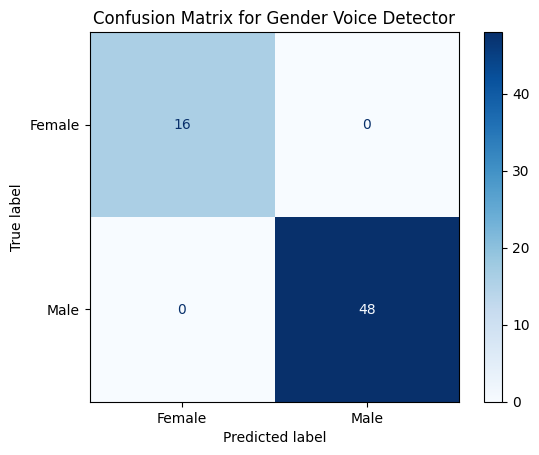

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import torch
from torch.utils.data import DataLoader

# Create a DataLoader for evaluation (without sampler for unbiased evaluation)
eval_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

# Set model to evaluation mode
model.eval()

# Collect predictions and true labels
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in eval_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Define class names based on your dataset
class_names = ['Female', 'Male']  # 0 = Female, 1 = Male

# Plot confusion matrix and save to file
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title('Confusion Matrix for Gender Voice Detector')
plt.savefig('gender_confusion_matrix.png')

In [21]:
# ------------------------- Combined Deepfake & Gender Prediction -------------------------
import torch
import torchaudio
import torch.nn.functional as F

# Load Deepfake model
deepfake_model = CNNVoiceDetector().to(device)
deepfake_model.load_state_dict(torch.load("deepfake_voice_detector.pth", map_location=device))
deepfake_model.eval()

# Load Gender model
gender_model = GenderCNN().to(device)
gender_model.load_state_dict(torch.load("gender_detector.pth", map_location=device))
gender_model.eval()

def combined_predict(file_path, transform, max_frames=100):
    try:
        waveform, sr = torchaudio.load(file_path)
    except Exception as e:
        return f"Error loading audio: {e}"
    
    waveform = waveform.mean(dim=0, keepdim=True)
    if sr != 16000:
        waveform = torchaudio.transforms.Resample(sr, 16000)(waveform)
    mfcc = transform(waveform)
    if mfcc.size(2) < max_frames:
        mfcc = F.pad(mfcc, (0, max_frames - mfcc.size(2)))
    else:
        mfcc = mfcc[:, :, :max_frames]
    
    mfcc = mfcc.unsqueeze(0).to(device)

    # Deepfake prediction
    with torch.no_grad():
        df_output = deepfake_model(mfcc)
        _, df_pred = torch.max(df_output, 1)
        df_label = "Real" if df_pred.item() == 0 else "Fake"
    
    # Gender prediction
    with torch.no_grad():
        gender_output = gender_model(mfcc)
        _, gender_pred = torch.max(gender_output, 1)
        gender_label = "Female" if gender_pred.item() == 0 else "Male"
    
    return df_label, gender_label

# Example usage on new file
file_path = r"linus-original-DEMO.mp3"  # Change to your file
df_label, gender_label = combined_predict(file_path, mfcc_transform)
print(f"Deepfake Prediction: {df_label}, Gender Prediction: {gender_label}")



Deepfake Prediction: Real, Gender Prediction: Male
